In [7]:
import os
print(os.getcwd())


d:\projects\notebook-codes\industrial


In [8]:
os.listdir()


['.venv', 'data', 'h.ipynb', 'main.ipynb', 'output.png', 'output1.png']

In [ ]:
import pandas as pd

train_df = pd.read_csv(r"D:\projects\notebook-codes\industrial\data\train.csv")
train_df.head()


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [11]:
import pandas as pd

train_df = pd.read_csv(r"D:\projects\notebook-codes\industrial\data\train.csv")
train_df.head()


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [12]:
train_df[['ImageId', 'ClassId']] = train_df['ImageId_ClassId'].str.split('_', expand=True)
train_df['ClassId'] = train_df['ClassId'].astype(int)

train_df.head()


KeyError: 'ImageId_ClassId'

In [ ]:
print(train_df.columns)
train_df.head()


Index(['ImageId', 'ClassId', 'EncodedPixels'], dtype='object')


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
# Ensure ClassId is integer
train_df['ClassId'] = train_df['ClassId'].astype(int)

# Check basic info
print(train_df.info())
print(train_df.head())

# Group by ImageId if needed (some images may have multiple ClassIds)
grouped = train_df.groupby('ImageId')['ClassId'].apply(list).reset_index()
print(grouped.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int32 
 2   EncodedPixels  7095 non-null   object
dtypes: int32(1), object(2)
memory usage: 138.7+ KB
None
         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
         ImageId ClassId
0  0002cc93b.jpg     [1]
1  0007a71bf.jpg     [3]
2  000a4bcdd.jpg     [1]
3  000f6bf48.jpg     [4]
4  0014fce06.jpg     [3]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Pick one image with a defect
sample_row = train_df[train_df['EncodedPixels'].notnull()].iloc[0]
image_id = sample_row['ImageId']
class_id = sample_row['ClassId']
mask_rle = sample_row['EncodedPixels']

# Load image
img_path = rf"D:\projects\notebook-codes\industrial\data\train_images\{image_id}"
image = np.array(Image.open(img_path))


In [ ]:
def rle_decode(mask_rle, shape=(256, 1600)):
    '''
    mask_rle: run-length string
    shape: (height, width)
    '''
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


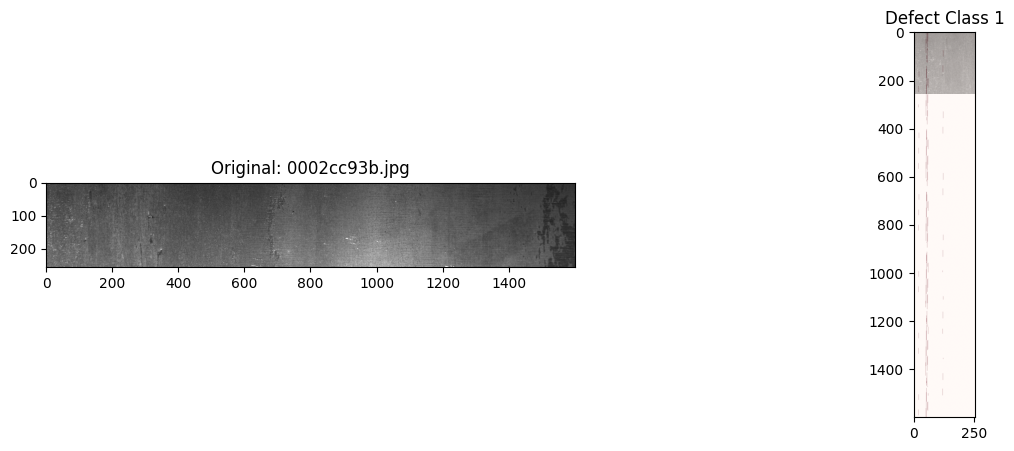

In [ ]:
mask = rle_decode(mask_rle)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title(f"Original: {image_id}")

plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap="Reds")  # overlay mask
plt.title(f"Defect Class {class_id}")
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# Paths
DATA_DIR = r"D:\projects\notebook-codes\industrial\data"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train_images")
train_csv = os.path.join(DATA_DIR, "train.csv")


In [ ]:
train_df = pd.read_csv(train_csv)
train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df.head()


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
def rle_decode(mask_rle, shape=(256, 1600)):
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [ ]:
class SteelDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, img_size=(256,256)):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.img_size = img_size
        self.image_ids = df['ImageId'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.img_size))
        
        # Multi-channel mask
        mask = np.zeros((self.img_size[0], self.img_size[1], 4), dtype=np.uint8)
        records = self.df[self.df['ImageId']==image_id]
        for _, row in records.iterrows():
            class_idx = row['ClassId'] - 1
            mask[..., class_idx] = rle_decode(row['EncodedPixels'], shape=(256,1600))
            mask = np.array(Image.fromarray(mask[..., class_idx]).resize(self.img_size))[:, :, np.newaxis]
        
        # Transpose to (C,H,W) for PyTorch
        image = torch.tensor(image.transpose(2,0,1), dtype=torch.float)/255.0
        mask = torch.tensor(mask.transpose(2,0,1), dtype=torch.float)
        
        return image, mask


In [ ]:
dataset = SteelDataset(train_df, TRAIN_IMG_DIR)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
class UNet(nn.Module):
    def __init__(self, n_classes=4):
        super(UNet, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3,64,3,padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.Conv2d(128,128,3,padding=1), nn.ReLU())
        
        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(128,64,3,padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        
        self.out = nn.Conv2d(64, n_classes, 1)
    
    def forward(self,x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = self.up1(e2)
        d1 = self.dec1(torch.cat([d1,e1],dim=1))
        return self.out(d1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
class SteelDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, img_size=(256,256)):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.img_size = img_size
        self.image_ids = df['ImageId'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.img_size))
        
        # Multi-channel mask
        mask = np.zeros((self.img_size[0], self.img_size[1], 4), dtype=np.uint8)
        records = self.df[self.df['ImageId']==image_id]
        for _, row in records.iterrows():
            class_idx = row['ClassId'] - 1
            single_mask = rle_decode(row['EncodedPixels'], shape=(256,1600))
            # Resize mask to img_size
            single_mask = np.array(Image.fromarray(single_mask).resize(self.img_size))
            mask[..., class_idx] = single_mask
        
        # Transpose to (C,H,W) for PyTorch
        image = torch.tensor(image.transpose(2,0,1), dtype=torch.float)/255.0
        mask = torch.tensor(mask.transpose(2,0,1), dtype=torch.float)
        
        return image, mask


In [ ]:
def rle_decode(mask_rle, shape=(256,1600)):
    """
    mask_rle: run-length string
    shape: (height, width) of the original image
    returns: 2D numpy array mask
    """
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # Reshape and transpose to get correct orientation
    return img.reshape((shape[1], shape[0])).T


In [ ]:
class SteelDataset(Dataset):
    def __init__(self, df, img_dir, img_size=(256,256)):
        self.df = df
        self.img_dir = img_dir
        self.img_size = img_size
        self.image_ids = df['ImageId'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.img_size))
        
        # Multi-channel mask
        mask = np.zeros((self.img_size[0], self.img_size[1], 4), dtype=np.uint8)
        records = self.df[self.df['ImageId']==image_id]
        for _, row in records.iterrows():
            class_idx = row['ClassId'] - 1
            single_mask = rle_decode(row['EncodedPixels'], shape=(256,1600))
            single_mask = np.array(Image.fromarray(single_mask).resize(self.img_size))
            mask[..., class_idx] = single_mask
        
        # Convert to tensors (C,H,W)
        image = torch.tensor(image.transpose(2,0,1), dtype=torch.float)/255.0
        mask = torch.tensor(mask.transpose(2,0,1), dtype=torch.float)
        
        return image, mask


In [ ]:
def dice_coef(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2*intersection + smooth) / (union + smooth)).mean().item()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred*target).sum(dim=(1,2,3))
    return ((intersection + smooth) / (union + smooth)).mean().item()


In [ ]:
import torch.nn.functional as F

model.eval()
dice_list, iou_list = [], []
class_metrics = {i: {'precision': [], 'recall': [], 'f1': []} for i in range(4)}

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = torch.sigmoid(model(images))
        
        # Dice / IoU
        dice_list.append(dice_coef(outputs, masks))
        iou_list.append(iou_score(outputs, masks))
        
        # Per-class metrics
        for i in range(4):
            pred_class = (outputs[:,i] > 0.5).cpu().numpy().flatten()
            true_class = masks[:,i].cpu().numpy().flatten()
            tp = ((pred_class==1) & (true_class==1)).sum()
            fp = ((pred_class==1) & (true_class==0)).sum()
            fn = ((pred_class==0) & (true_class==1)).sum()
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = 2*precision*recall/(precision+recall+1e-6)
            class_metrics[i]['precision'].append(precision)
            class_metrics[i]['recall'].append(recall)
            class_metrics[i]['f1'].append(f1)


NameError: name 'test_loader' is not defined

     Class     Precision    Recall      F1-score      Dice       IoU
0  Defect1  6.338842e-05  0.000750  8.654736e-05  0.047799  0.025729
1  Defect2  8.852300e-08  0.000037  1.757908e-07  0.047799  0.025729
2  Defect3  6.455043e-02  0.416525  1.009866e-01  0.047799  0.025729
3  Defect4  1.057028e-02  0.157868  1.905654e-02  0.047799  0.025729


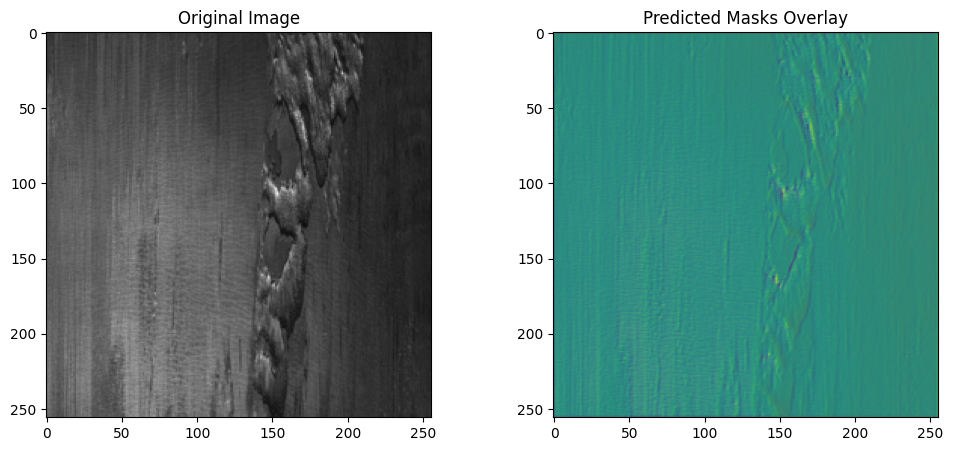

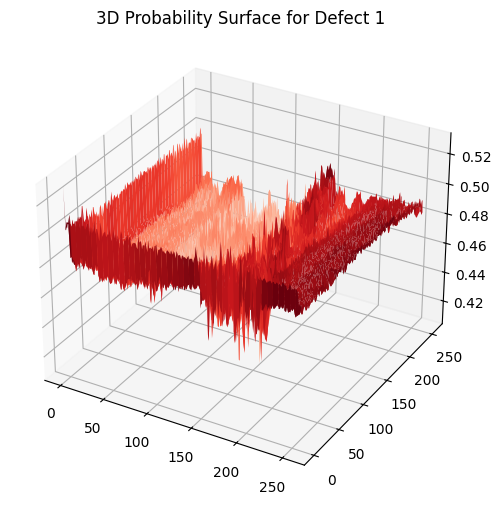

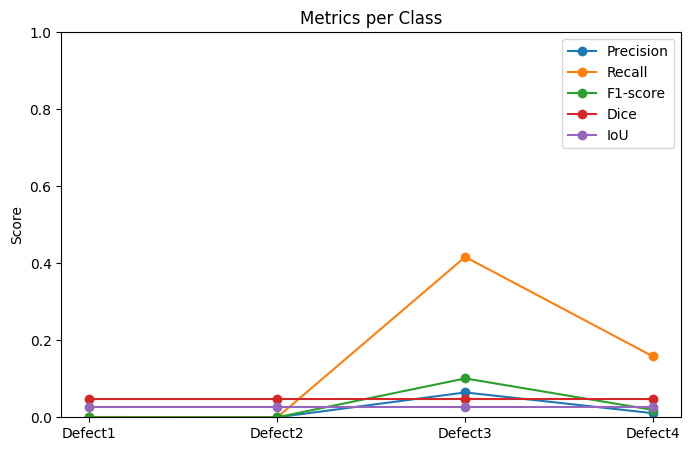

In [ ]:
# -------------------------------
# 1️⃣ Imports
# -------------------------------
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

# -------------------------------
# 2️⃣ Paths
# -------------------------------
TRAIN_IMG_DIR = r"D:\projects\notebook-codes\industrial\data\train_images"
TEST_IMG_DIR = r"D:\projects\notebook-codes\industrial\data\test_images"
TRAIN_CSV = r"D:\projects\notebook-codes\industrial\data\train.csv"

# -------------------------------
# 3️⃣ Load CSV
# -------------------------------
train_df = pd.read_csv(TRAIN_CSV)

# -------------------------------
# 4️⃣ RLE Decode
# -------------------------------
def rle_decode(mask_rle, shape=(256,1600)):
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0])).T  # transpose to correct orientation

# -------------------------------
# 5️⃣ Dataset
# -------------------------------
class SteelDataset(Dataset):
    def __init__(self, df, img_dir, img_size=(256,256)):
        self.df = df
        self.img_dir = img_dir
        self.img_size = img_size
        self.image_ids = df['ImageId'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.img_size))
        
        mask = np.zeros((self.img_size[0], self.img_size[1], 4), dtype=np.uint8)
        records = self.df[self.df['ImageId']==image_id]
        for _, row in records.iterrows():
            class_idx = row['ClassId'] - 1
            single_mask = rle_decode(row['EncodedPixels'], shape=(256,1600))
            single_mask = np.array(Image.fromarray(single_mask).resize(self.img_size))
            mask[..., class_idx] = single_mask
        
        image = torch.tensor(image.transpose(2,0,1), dtype=torch.float)/255.0
        mask = torch.tensor(mask.transpose(2,0,1), dtype=torch.float)
        return image, mask

# -------------------------------
# 6️⃣ Train/Test Split & Dataloaders
# -------------------------------
image_ids = train_df['ImageId'].unique()
train_ids, test_ids = train_test_split(image_ids, test_size=0.15, random_state=42)
train_data = train_df[train_df['ImageId'].isin(train_ids)]
test_data = train_df[train_df['ImageId'].isin(test_ids)]

train_dataset = SteelDataset(train_data, TRAIN_IMG_DIR)
test_dataset = SteelDataset(test_data, TRAIN_IMG_DIR)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# -------------------------------
# 7️⃣ Metrics
# -------------------------------
def dice_coef(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2*intersection + smooth)/(union+smooth)).mean().item()

def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred*target).sum(dim=(1,2,3))
    return ((intersection + smooth)/(union+smooth)).mean().item()

# -------------------------------
# 8️⃣ Example Model (U-Net or placeholder)
# -------------------------------
# Replace with your trained segmentation model
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 4, kernel_size=3, padding=1)
    def forward(self,x):
        return torch.sigmoid(self.conv(x))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DummyModel().to(device)

# -------------------------------
# 9️⃣ Testing & Benchmark
# -------------------------------
model.eval()
dice_list, iou_list = [], []
class_metrics = {i: {'precision': [], 'recall': [], 'f1': []} for i in range(4)}

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        dice_list.append(dice_coef(outputs, masks))
        iou_list.append(iou_score(outputs, masks))
        
        for i in range(4):
            pred_class = (outputs[:,i] > 0.5).cpu().numpy().flatten()
            true_class = masks[:,i].cpu().numpy().flatten()
            tp = ((pred_class==1) & (true_class==1)).sum()
            fp = ((pred_class==1) & (true_class==0)).sum()
            fn = ((pred_class==0) & (true_class==1)).sum()
            precision = tp / (tp+fp+1e-6)
            recall = tp / (tp+fn+1e-6)
            f1 = 2*precision*recall/(precision+recall+1e-6)
            class_metrics[i]['precision'].append(precision)
            class_metrics[i]['recall'].append(recall)
            class_metrics[i]['f1'].append(f1)

metrics_df = pd.DataFrame({
    'Class': ['Defect1','Defect2','Defect3','Defect4'],
    'Precision': [np.mean(class_metrics[i]['precision']) for i in range(4)],
    'Recall': [np.mean(class_metrics[i]['recall']) for i in range(4)],
    'F1-score': [np.mean(class_metrics[i]['f1']) for i in range(4)],
    'Dice': [np.mean(dice_list) for i in range(4)],
    'IoU': [np.mean(iou_list) for i in range(4)]
})

print(metrics_df)

# -------------------------------
# 10️⃣ Visualization
# -------------------------------
# 2D overlay
sample_image, sample_mask = test_dataset[0]
pred_mask = model(sample_image.unsqueeze(0).to(device)).detach().cpu().numpy()[0]


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(sample_image.permute(1,2,0))
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(sample_image.permute(1,2,0))
for i in range(4):
    plt.imshow(pred_mask[i], alpha=0.4)
plt.title("Predicted Masks Overlay")
plt.show()

# 3D surface plot for Defect 1
mask_3d = pred_mask[0]
x = np.arange(mask_3d.shape[1])
y = np.arange(mask_3d.shape[0])
X, Y = np.meshgrid(x, y)
Z = mask_3d

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='Reds')
ax.set_title("3D Probability Surface for Defect 1")
plt.show()

# Line graph of metrics
plt.figure(figsize=(8,5))
for metric in ['Precision','Recall','F1-score','Dice','IoU']:
    plt.plot(metrics_df['Class'], metrics_df[metric], marker='o', label=metric)
plt.title("Metrics per Class")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend()
plt.show()


<frozen importlib._bootstrap>:488: RuntimeWarning: The global interpreter lock (GIL) has been enabled to load module 'pandas._libs.pandas_parser', which has not declared that it can run safely without the GIL. To override this behavior and keep the GIL disabled (at your own risk), run with PYTHON_GIL=0 or -Xgil=0.


Epoch 1/5 - Loss: 0.7733
Epoch 2/5 - Loss: 0.6682
Epoch 2/5 - Loss: 0.6682
Epoch 3/5 - Loss: 0.6401
Epoch 3/5 - Loss: 0.6401
Epoch 4/5 - Loss: 0.6191
Epoch 4/5 - Loss: 0.6191
Epoch 5/5 - Loss: 0.5995
Epoch 5/5 - Loss: 0.5995


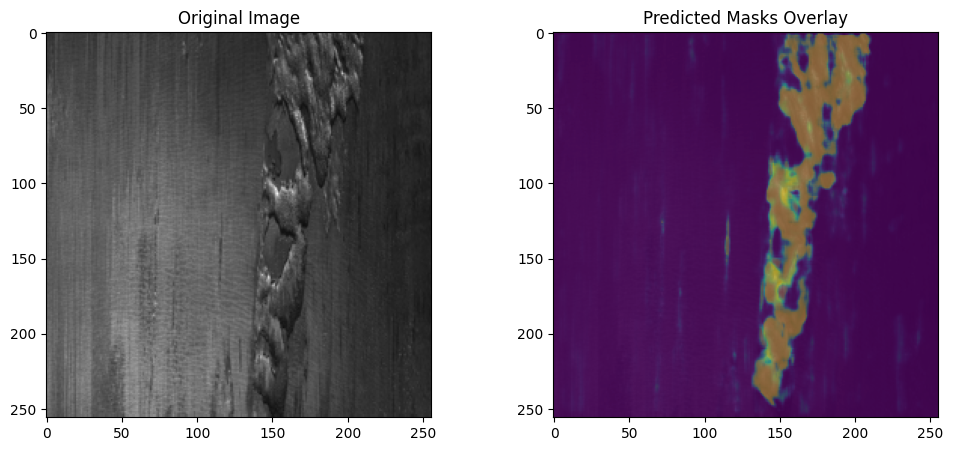

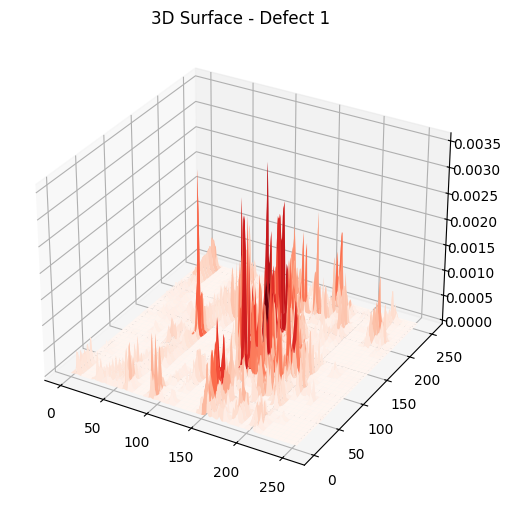

In [1]:
# -------------------------------
# 1️⃣ Imports
# -------------------------------
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------
# 2️⃣ Paths
# -------------------------------
TRAIN_IMG_DIR = r"D:\projects\notebook-codes\industrial\data\train_images"
TRAIN_CSV = r"D:\projects\notebook-codes\industrial\data\train.csv"

# -------------------------------
# 3️⃣ Load CSV
# -------------------------------
train_df = pd.read_csv(TRAIN_CSV)

# -------------------------------
# 4️⃣ RLE Decode
# -------------------------------
def rle_decode(mask_rle, shape=(256,1600)):
    if pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0])).T  # transpose to correct orientation

# -------------------------------
# 5️⃣ Dataset with Augmentation
# -------------------------------
class SteelDataset(Dataset):
    def __init__(self, df, img_dir, img_size=(256,256), augment=False):
        self.df = df
        self.img_dir = img_dir
        self.img_size = img_size
        self.image_ids = df['ImageId'].unique()
        self.augment = augment
        self.transform = T.Compose([
            T.ToTensor()
        ])
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, image_id)
        image = np.array(Image.open(img_path).convert("RGB").resize(self.img_size))
        
        mask = np.zeros((self.img_size[0], self.img_size[1], 4), dtype=np.uint8)
        records = self.df[self.df['ImageId']==image_id]
        for _, row in records.iterrows():
            class_idx = row['ClassId'] - 1
            single_mask = rle_decode(row['EncodedPixels'], shape=(256,1600))
            single_mask = np.array(Image.fromarray(single_mask).resize(self.img_size))
            mask[..., class_idx] = single_mask
        
        if self.augment:
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=1).copy()
                mask = np.flip(mask, axis=1).copy()

        
        image = torch.tensor(image.transpose(2,0,1), dtype=torch.float)/255.0
        mask = torch.tensor(mask.transpose(2,0,1), dtype=torch.float)
        return image, mask

# -------------------------------
# 6️⃣ Train/Test Split & Dataloaders
# -------------------------------
image_ids = train_df['ImageId'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.15, random_state=42)
train_data = train_df[train_df['ImageId'].isin(train_ids)]
val_data = train_df[train_df['ImageId'].isin(val_ids)]

train_dataset = SteelDataset(train_data, TRAIN_IMG_DIR, augment=True)
val_dataset = SteelDataset(val_data, TRAIN_IMG_DIR, augment=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# -------------------------------
# 7️⃣ U-Net Model
# -------------------------------
class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=4):
        super().__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        
        self.final = nn.Conv2d(64, out_ch, 1)
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        b = self.bottleneck(self.pool4(e4))
        
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        out = torch.sigmoid(self.final(d1))
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

# -------------------------------
# 8️⃣ Loss: BCE + Dice
# -------------------------------
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
    
    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)
        smooth = 1e-6
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)
        intersection = (preds_flat * targets_flat).sum()
        dice_loss = 1 - (2*intersection + smooth)/(preds_flat.sum() + targets_flat.sum() + smooth)
        return bce_loss + dice_loss

criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -------------------------------
# 9️⃣ Training Loop
# -------------------------------
epochs = 5  # increase to 20+ for real training

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

# -------------------------------
# 1️⃣0️⃣ Metrics & Visualization
# -------------------------------
def dice_coef(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return ((2*intersection + smooth)/(union+smooth)).mean().item()

# Example: visualize one sample
model.eval()
sample_image, sample_mask = val_dataset[0]
with torch.no_grad():
    pred_mask = model(sample_image.unsqueeze(0).to(device)).detach().cpu().numpy()[0]

# 2D overlay
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(sample_image.permute(1,2,0))
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(sample_image.permute(1,2,0))
for i in range(4):
    plt.imshow(pred_mask[i], alpha=0.4)
plt.title("Predicted Masks Overlay")
plt.show()

# 3D surface plot
mask_3d = pred_mask[0]
x = np.arange(mask_3d.shape[1])
y = np.arange(mask_3d.shape[0])
X, Y = np.meshgrid(x, y)
Z = mask_3d
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='Reds')
ax.set_title("3D Surface - Defect 1")
plt.show()


In [ ]:
def dice_coeff(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [1]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device="cpu"):
    model.eval()  # set model to evaluation mode
    criterion = nn.CrossEntropyLoss()
    
    all_labels = []
    all_preds = []
    total_loss = 0.0
    
    with torch.no_grad():  # no gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Predicted class
            preds = torch.argmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    
    print(f"\nValidation Results:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return avg_loss, accuracy, precision, recall, f1


In [24]:
# Quick (re)create DataLoaders only - safe, no training
from sklearn.model_selection import train_test_split
# Use existing train_df, TRAIN_IMG_DIR and SteelDataset definitions from earlier cells
image_ids = train_df['ImageId'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.15, random_state=42)
train_data = train_df[train_df['ImageId'].isin(train_ids)]
val_data = train_df[train_df['ImageId'].isin(val_ids)]
train_dataset = SteelDataset(train_data, TRAIN_IMG_DIR, img_size=(256,256), augment=True)
val_dataset = SteelDataset(val_data, TRAIN_IMG_DIR, img_size=(256,256), augment=False)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
print('Created train_loader and val_loader:', len(train_dataset), 'train samples,', len(val_dataset), 'val samples')


Created train_loader and val_loader: 5666 train samples, 1000 val samples
